<a href="https://colab.research.google.com/github/hoangDEVteams/deeplearning/blob/main/animal10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import file kaglle.json để tải dữ liệu dataset từ kaggle

In [ ]:
from google.colab import files
# Cài đặt Kaggle API
!pip install -q kaggle
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hoanglearning","key":"139107b7e925ade6c0a1bdd6e66865c6"}'}

đây là file cấu hình của kaggle dùng để tải dataset

In [2]:
import os

# Tạo thư mục ~/.kaggle nếu chưa có
os.makedirs("/root/.kaggle", exist_ok=True)

# Di chuyển file kaggle.json vào thư mục ~/.kaggle
!mv kaggle.json /root/.kaggle/

# Đặt quyền truy cập (bắt buộc để tránh lỗi)
!chmod 600 /root/.kaggle/kaggle.json


mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


tải dataset từ kaggle

In [3]:
!kaggle datasets download -d alessiocorrado99/animals10

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
 99% 582M/586M [00:14<00:00, 44.3MB/s]
100% 586M/586M [00:14<00:00, 41.7MB/s]


In [5]:
import zipfile

# Giải nén file ZIP
with zipfile.ZipFile("animals10.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/data")

print("✅ Giải nén thành công!")

✅ Giải nén thành công!


kiểm tra dữ liệu

In [6]:
import os
print(os.listdir("/content/data"))

['translate.py', 'raw-img']


In [7]:
import glob

image_paths = glob.glob("/content/data/**/*.jpg", recursive=True)  # Lấy tất cả file .jpg
print(f"📸 Tìm thấy {len(image_paths)} ảnh trong dataset.")
print("📜 Một số đường dẫn ảnh:")
print("\n".join(image_paths[:5]))  # In 5 ảnh đầu tiên


📸 Tìm thấy 1919 ảnh trong dataset.
📜 Một số đường dẫn ảnh:
/content/data/raw-img/farfalla/eb31b20e2cfd033ed1584d05fb1d4e9fe777ead218ac104497f5c97faeebb5bb_640.jpg
/content/data/raw-img/farfalla/ea37b00e29f0093ed1584d05fb1d4e9fe777ead218ac104497f5c97faeebb5bb_640.jpg
/content/data/raw-img/farfalla/ea36b7072ff0003ed1584d05fb1d4e9fe777ead218ac104497f5c97faee9bdba_640.jpg
/content/data/raw-img/farfalla/ea36b90c2cf3053ed1584d05fb1d4e9fe777ead218ac104497f5c97faee9bdba_640.jpg
/content/data/raw-img/farfalla/e837b3072ef7083ed1584d05fb1d4e9fe777ead218ac104497f5c97faee9bdba_640.jpg


Xử lý dữ liệu

Bạn cần chia dataset thành 3 phần để huấn luyện và đánh giá mô hình:

Train set (~70-80%): Dùng để huấn luyện.

Validation set (~10-15%): Dùng để tối ưu mô hình, tránh overfitting.


Test set (~10-15%): Đánh giá mô hình sau khi train.

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Định nghĩa các đường dẫn
dataset_dir = "/content/data/raw-img"
img_size = (64, 64)  # Resize ảnh
batch_size = 128

# Tạo ImageDataGenerator cho train và validation
datagen = ImageDataGenerator(
    rescale=1./255,        # Chuẩn hóa ảnh
    rotation_range=20,     # Xoay ảnh ngẫu nhiên
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,  # Lật ngang ảnh
    validation_split=0.2   # Chia 80% train - 20% validation
)

# Load dữ liệu train
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

# Load dữ liệu validation
val_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    dataset_dir,  # Thư mục chứa ảnh test
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Không shuffle để giữ thứ tự file ảnh
)


Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.
Found 26179 images belonging to 10 classes.


mô hình CNN

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [10]:
img_size = 64

# Xây dựng model CNN
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    BatchNormalization(scale=False, center=False),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(scale=False, center=False),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(scale=False, center=False),
    Activation('relu'),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(scale=False, center=False),

    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Hiển thị cấu trúc model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 62, 62, 32)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 29, 29, 64)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 4, 256)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 489,354 (1.87 MB)

 Trainable params: 488,394 (1.86 MB)

 Non-trainable params: 960 (3.75 KB)

epochs trong huấn luyện mô hình deep learning là số lần toàn bộ dataset được đưa qua mô hình trong quá trình huấn luyện.

📌 Giải thích chi tiết:
Khi bạn huấn luyện mô hình, dữ liệu được chia thành nhiều batch (tập nhỏ).

Một epoch là khi mô hình được huấn luyện trên toàn bộ dữ liệu huấn luyện một lần.

Nếu bạn đặt epochs = 20, nghĩa là mô hình sẽ lặp qua toàn bộ dữ liệu 20 lần.

Giả sử bạn có 1.000 ảnh trong dataset và batch_size=32, thì:

Mỗi batch có 32 ảnh.
Số batch mỗi epoch = 1000 / 32 ≈ 31 batch.
Nếu epochs = 20, mô hình sẽ chạy 31 × 20 = 620 batch.

In [11]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    epochs=20,
    validation_steps=len(val_generator)
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 77s 411ms/step - accuracy: 0.2531 - loss: 2.1589 - val_accuracy: 0.1843 - val_loss: 3.5372
Epoch 2/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 60s 365ms/step - accuracy: 0.4246 - loss: 1.7127 - val_accuracy: 0.1929 - val_loss: 2.5272
Epoch 3/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 82s 366ms/step - accuracy: 0.4884 - loss: 1.5132 - val_accuracy: 0.3272 - val_loss: 2.0251
Epoch 4/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 83s 374ms/step - accuracy: 0.5362 - loss: 1.3915 - val_accuracy: 0.5078 - val_loss: 1.4029
Epoch 5/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 81s 367ms/step - accuracy: 0.5708 - loss: 1.2985 - val_accuracy: 0.5300 - val_loss: 1.5367
Epoch 6/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 82s 369ms/step - accuracy: 0.5954 - loss: 1.2292 - val_accuracy: 0.4962 - val_loss: 1.5914
Epoch 7/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 60s 367ms/step - accuracy: 0.6189 - loss: 1.1620 - val_accuracy: 0.4589 - val_loss: 1.6059
Epoch 8/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 82s 367ms/step - accuracy: 0.6344 - loss: 1

In [38]:
from google.colab import files

uploaded = files.upload()  # Hộp thoại sẽ hiện ra cho bạn chọn file

Saving cat1.jpg to cat1.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


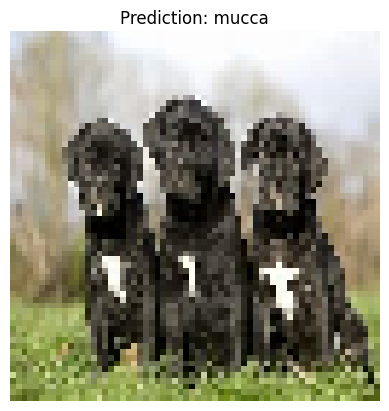

Dự đoán: mucca, Xác suất: 0.3821


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Lấy danh sách nhãn từ train_generator
class_names = list(train_generator.class_indices.keys())

def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=(64, 64))  # Resize ảnh
    img_array = image.img_to_array(img) / 255.0  # Chuẩn hóa
    img_array = np.expand_dims(img_array, axis=0)  # Thêm batch dimension

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)  # Lấy nhãn có xác suất cao nhất
    class_name = class_names[predicted_class]  # Tìm tên lớp dự đoán

    # Hiển thị ảnh + dự đoán
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction: {class_name}")
    plt.show()

    print(f"Dự đoán: {class_name}, Xác suất: {max(prediction[0]):.4f}")

# Gọi hàm dự đoán
predict_image("cane.jpg", model)


In [ ]:
from tensorflow.keras.models import load_model

# Load mô hình đã lưu
model = load_model("cnn_model.h5")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'cnn_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)